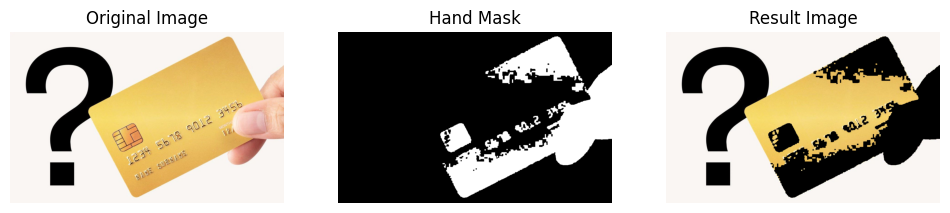

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('08 - Ew3a soba3ak ya3am.jpg')

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for skin color in HSV
lower_skin = np.array([0, 20, 70], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

# Create a mask for skin color
mask = cv2.inRange(hsv, lower_skin, upper_skin)

# Remove small noise from the mask
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

# Create an inverse mask
mask_inv = cv2.bitwise_not(mask)

# Extract the hand region from the image
hand_region = cv2.bitwise_and(image, image, mask=mask)

# Remove the hand region from the image
result = cv2.bitwise_and(image, image, mask=mask_inv)

# Convert images from BGR to RGB for Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hand_region_rgb = cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Hand Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Result Image')
plt.imshow(result_rgb)
plt.axis('off')

plt.show()


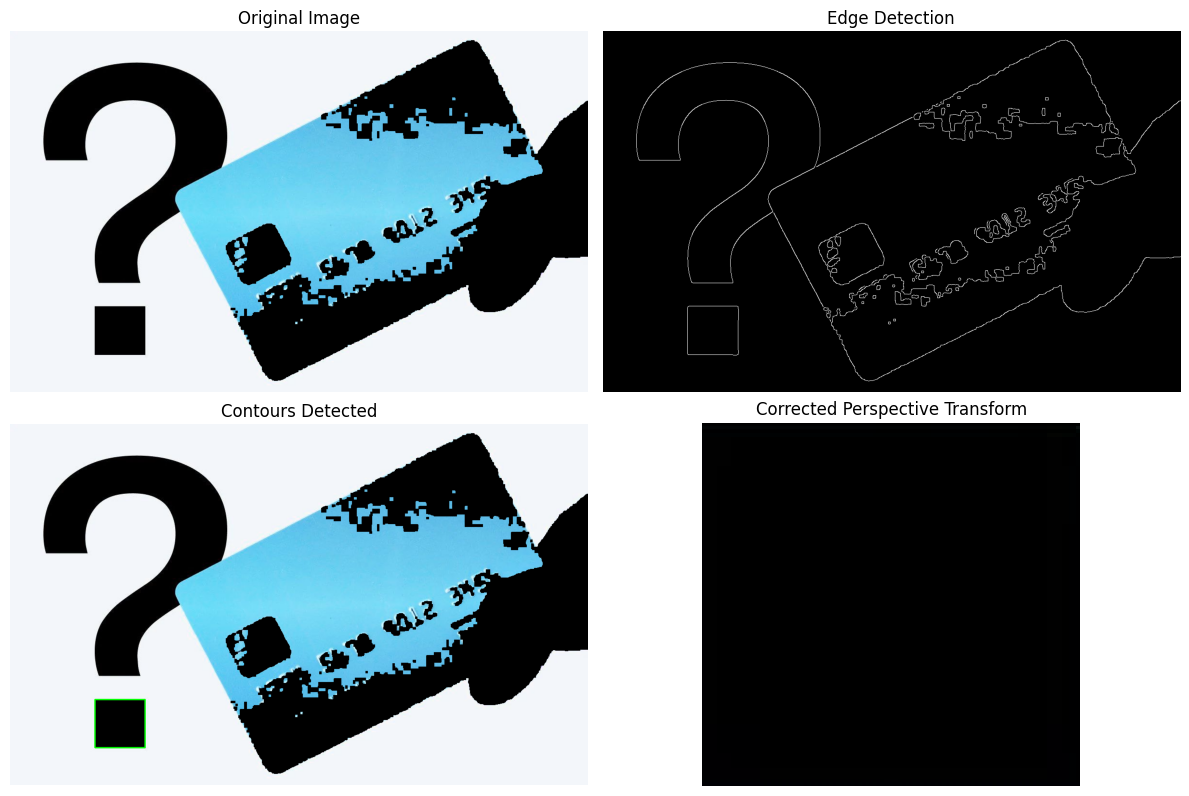

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_intersection(p1, p2, p3, p4):
    """Find the intersection point of two lines defined by (p1, p2) and (p3, p4)."""
    def line_params(p1, p2):
        A = p2[1] - p1[1]
        B = p1[0] - p2[0]
        C = A * p1[0] + B * p1[1]
        return A, B, -C

    A1, B1, C1 = line_params(p1, p2)
    A2, B2, C2 = line_params(p3, p4)

    det = A1 * B2 - A2 * B1
    if det == 0:
        return None  # Lines are parallel

    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det
    return np.array([x, y])

def extend_line(p1, p2, length=1000):
    """Extend the line defined by points p1 and p2."""
    direction = p2 - p1
    norm = np.linalg.norm(direction)
    direction /= norm
    p1_extended = p1 - direction * length
    p2_extended = p2 + direction * length
    return p1_extended, p2_extended

def complete_rectangle(points):
    if len(points) < 2:
        return np.array(points, dtype="float32")

    points = np.array(points, dtype="float32")
    extended_lines = []
    for i in range(len(points)):
        p1 = points[i]
        p2 = points[(i + 1) % len(points)]
        p1_ext, p2_ext = extend_line(p1, p2)
        extended_lines.append((p1_ext, p2_ext))

    intersections = []
    for i in range(len(extended_lines)):
        p1, p2 = extended_lines[i]
        p3, p4 = extended_lines[(i + 1) % len(extended_lines)]
        intersection = find_intersection(p1, p2, p3, p4)
        if intersection is not None:
            intersections.append(intersection)

    if len(intersections) == 4:
        return np.array(intersections, dtype="float32")
    
    return np.array(points, dtype="float32")

# Load the image
image = result_rgb
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Preprocess the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Detect contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def find_card_contour(contours):
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) >= 4 and cv2.contourArea(approx) > 1000:
            return approx
    return None

# Find card contour
approx = find_card_contour(contours)

if approx is None:
    print("No valid card contour found. Using edge bounding box.")
    x, y, w, h = cv2.boundingRect(edges)
    approx = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ], dtype="float32")
else:
    approx = approx.reshape(-1, 2)

    if len(approx) < 4:
        approx = complete_rectangle(approx)

# Sort the points to ensure correct order (top-left, top-right, bottom-right, bottom-left)
def order_points(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    ordered_pts = np.zeros((4, 2), dtype="float32")
    ordered_pts[0] = pts[np.argmin(s)]
    ordered_pts[2] = pts[np.argmax(s)]
    ordered_pts[1] = pts[np.argmin(diff)]
    ordered_pts[3] = pts[np.argmax(diff)]
    return ordered_pts

# Ordered points
ordered_approx = order_points(approx.reshape(4, 2))

# Perspective Transform
def four_point_transform(image, pts):
    rect = np.array(pts, dtype="float32")
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# Perform perspective transform
warped_image = four_point_transform(image, ordered_approx)

# Check orientation and rotate if necessary
def correct_orientation(image):
    (h, w) = image.shape[:2]
    if w < h:
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, 90, 1.0)
        rotated = cv2.warpAffine(image, M, (h, w), flags=cv2.INTER_CUBIC)
        return rotated
    return image

# Correct orientation if needed
corrected_image = correct_orientation(warped_image)

# Display results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Edge Detection')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Contours Detected')
contour_image = image.copy()
if len(approx) > 0:
    approx = np.int32(ordered_approx).reshape(-1, 2)  # Ensure the points are integers
    cv2.drawContours(contour_image, [approx], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Corrected Perspective Transform')
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()
